# **ROAD SEGMENTATION**

**Objective:**
The global market for self-driving cars has been on a rise with the market size projected to grow from 20.3 million units in 2021 to 62.4 million units by 2030, a CAGR on 13.3%. Among the many challenges associated with designing self-driving cars, one challenge that we are particularly interested in is designing a machine learning model that can accurately detect road lanes. In this project I have created an image segmentation model that tries to accurately identify the pixels corresponding to the road from a given dash cam image.

**Dataset:**
The dataset that I will be using in this project is the Cambridge-driving Labeled Video Database (CamVid) which is a collection of frames from videos taken from a front dash cam of cars. The dataset is labelled with 32 categories that includes buildings, trees, sidewalk, etc. but due to computational limitations we will be working with only a single class “road”. So, we will be working with a binary segmentation problem, where road pixels would be indicated by 1 and the remaining pixels in the image would be indicated by 0.

**Accuracy Metrics:**
We used 2 metrics to evaluate our models: Intersection over Union (IoU) and Dice Score, both of which are metrics that quantify the degree of overlap in the true and the predicted image, where IoU is more sensitive to extreme values.

Intersection over Union (IoU): This metric gives the ratio of intersection area of true and predicted image to the union area true and predicted image.

Dice Score: This metric gives the ratio of two times the intersection area of true and predicted image to the sum of areas true and predicted image.

### CODE

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!unzip drive/My\ Drive/CamVid3.zip

Mounted at /content/drive
Archive:  drive/My Drive/CamVid3.zip
   creating: CamVid/test/
  inflating: CamVid/test/0001TP_008550.png  
  inflating: CamVid/test/0001TP_008580.png  
  inflating: CamVid/test/0001TP_008610.png  
  inflating: CamVid/test/0001TP_008640.png  
  inflating: CamVid/test/0001TP_008670.png  
  inflating: CamVid/test/0001TP_008700.png  
  inflating: CamVid/test/0001TP_008730.png  
  inflating: CamVid/test/0001TP_008760.png  
  inflating: CamVid/test/0001TP_008790.png  
  inflating: CamVid/test/0001TP_008820.png  
  inflating: CamVid/test/0001TP_008850.png  
  inflating: CamVid/test/0001TP_008880.png  
  inflating: CamVid/test/0001TP_008910.png  
  inflating: CamVid/test/0001TP_008940.png  
  inflating: CamVid/test/0001TP_008970.png  
  inflating: CamVid/test/0001TP_009000.png  
  inflating: CamVid/test/0001TP_009030.png  
  inflating: CamVid/test/0001TP_009060.png  
  inflating: CamVid/test/0001TP_009090.png  
  inflating: CamVid/test/0001TP_009120.png  
  inflating

In [2]:
!pip install -U segmentation-models-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 102 kB 867 kB/s 
     |████████████████████████████████| 376 kB 2.1 MB/s 
     |████████████████████████████████| 58 kB 4.2 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=0448ad8119416d864c523b26a6f5f38e41125401e60a433d716aa002af10b308
  Stored in directory: /root/.cache/pip/wheels/84/b9/90/25a0195cf95fb5533db96f1c77ea3f296b7cc86ae8ae48e3dc
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=8c180d6945c57a55ff8adb2e65e63064edfe2b79b114d380a0e13618172db0d2
  Stored in directory: /root/.cache/pip/wheels/ed/fa/b9/5c82b59d905f95542a192b883c0cc0082407ea2f54beb2f9e6
Successfully built efficientnet-pytorch pretrainedmodels


In [3]:
pip install pytorch-model-summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [168]:
from torch.utils.data import Dataset
from torchvision.transforms import Compose
from torchvision.transforms import Resize
from torchvision.transforms import ToTensor

import os
from PIL import Image
import numpy as np

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torch.nn import Module, Sequential, Conv2d, ConvTranspose2d, MaxPool2d, MaxUnpool2d, ReLU, BatchNorm2d, Dropout, Sigmoid
from pytorch_model_summary import summary

import torch
from numpy import asarray
import tensorflow as tf

import cv2
import numpy as np
from keras import backend as K

from torchvision.models.segmentation import deeplabv3_resnet101
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from random import random
from torchvision.transforms import functional as F

import segmentation_models_pytorch as smp

from torchvision.transforms import Normalize
from segmentation_models_pytorch import utils

In [169]:
x_train_dir = '/content/CamVid/train'
y_train_dir = '/content/CamVid/train_labels'
x_val_dir = '/content/CamVid/val'
y_val_dir = '/content/CamVid/val_labels'
x_test_dir = '/content/CamVid/test'
y_test_dir = '/content/CamVid/test_labels'

# 1. CNN model (Baseline)

Baseline CNN:
We first created a CNN architecture as a baseline for the lane segmentation problem. The baseline model contains two convolution (num_filters=64, filter_size=3, stride=2, activation=“relu”) and pooling layers (size=2) in the encoder section, and two transpose convolution and unpooling layers in the decoder section. The mean IoU score obtained on the validation set was about 61.85% and the mean dice score was about 63.32%

### 1.1 Defining the custom dataset

In [170]:
from torch.utils.data import Dataset
class CamVidDataset(Dataset):
    def __init__(self, images_dir, masks_dir=None, transforms=None, training_type=None):
        # Here we get names of all the images
        self.image_names = os.listdir(images_dir)

        # Defining the training _type and transforms
        self.training_type = training_type
        self.transforms = transforms

        # Defining the paths of images and masks
        self.images_paths = []
        self.masks_paths = []
        for image_name in self.image_names:
            self.images_paths.append(os.path.join(images_dir, image_name))
            if self.training_type=="train" or self.training_type=="val":
                self.masks_paths.append(os.path.join(masks_dir, image_name.split('.')[0] + '.png'))
    
    def __getitem__(self, i):
        
        if self.training_type=="train" or self.training_type=="val":
            image = Image.open(self.images_paths[i])
            mask = Image.open(self.masks_paths[i])

            # preprocessing of mask
            mask = np.array(mask)
            mask = (mask == 3)
            mask = Image.fromarray(mask)

            # application of transforms
            image = self.transforms(image)
            mask = self.transforms(mask)
            return image, mask
        
        else:
            # Reading the data
            image = Image.open(self.images_paths[i])
            
            # application of transforms
            image = self.transforms(image)
            return image
        
    def __len__(self):
        return len(self.image_names)

### 1.2 Data Exploration

In [171]:
# The images resized to 224 x 224
train_transforms = Compose([
    Resize((224, 224)),ToTensor()])

In [172]:
dataset = CamVidDataset(x_train_dir, y_train_dir, transforms=train_transforms, training_type='train')
image, gt_mask = dataset[0]
image.shape, gt_mask.shape

(torch.Size([3, 224, 224]), torch.Size([1, 224, 224]))

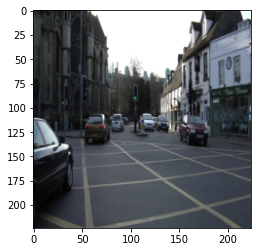

In [173]:
# Image 
plt.imshow(np.transpose(image, (1, 2, 0)))

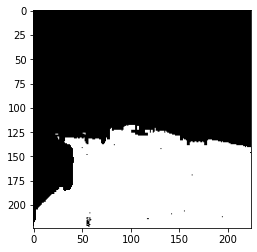

In [174]:
# Mask image
plt.imshow(gt_mask.squeeze(), cmap='gray')

In [175]:
# Creating batches
train_transforms = Compose([Resize((224, 224)),ToTensor()]) #resizing
train_dataset = CamVidDataset(x_train_dir, y_train_dir, 
    transforms=train_transforms,training_type='train') # creating an instance of custom dataset
train_loader = DataLoader(train_dataset, 
    batch_size=16,num_workers=2) # Load dataloader

for batch_x, batch_y in train_loader:
    break

batch_x.shape, batch_y.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16, 1, 224, 224]))

### 1.3 Define Model Architecture

In [176]:
# Model Architecture

class EncoderDecoder(Module):
    def __init__(self):
        super().__init__()

        # Defining the encoder
        self.encoder_block1 = Sequential(Conv2d(3, 64, 3, stride=2, padding=1), 
            ReLU())
        self.pool1 = MaxPool2d(2, return_indices=True)
        self.encoder_block2 = Sequential(
            Conv2d(64, 128, 3, stride=2, padding=1), ReLU())
        self.pool2 = MaxPool2d(2, return_indices=True)

        # Defining the decoder        
        self.unpool2 = MaxUnpool2d(2)
        self.decoder_upsample2 = ConvTranspose2d(128, 64, 3, stride=2, padding=1)
        self.decoder_non_linearity2 = ReLU()
        self.unpool1 = MaxUnpool2d(2)
        self.decoder_upsample1 = ConvTranspose2d(64, 64, 3, stride=2, padding=1)
        self.decoder_non_linearity1 = ReLU()

        # Output defined
        self.output_layer = Sequential( 
            Conv2d(64, 1, 3, stride=1, padding=1),
            Sigmoid()
        )

    def forward(self, x):
        #Getting input shape for the first blocks and getting pooling incides for pool1
        size_input_encoder_block1 = x.shape
        x = self.encoder_block1(x)
        x, indices_pool1 = self.pool1(x)

        #Getting input shape for the second block and getting pooling incides for pool2
        size_input_encoder_block2 = x.shape
        x = self.encoder_block2(x)
        x, indices_pool2 = self.pool2(x)

        # use pooling indices of pool 2
        x = self.unpool2(x, indices_pool2)
        # use input shape of encoder block 2
        x = self.decoder_upsample2(x, output_size=size_input_encoder_block2)
        x = self.decoder_non_linearity2(x)

        
        x = self.unpool1(x, indices_pool1)
        x = self.decoder_upsample1(x, output_size=size_input_encoder_block1)
        x = self.decoder_non_linearity1(x)
        x = self.output_layer(x)
        return x

In [177]:
# The model defined
model = EncoderDecoder()
model

EncoderDecoder(
  (encoder_block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder_block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (unpool2): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (decoder_upsample2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (decoder_non_linearity2): ReLU()
  (unpool1): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (decoder_upsample1): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (decoder_non_linearity1): ReLU()
  (output_layer): Sequential(
    (0): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Sigmoid()
  )
)

In [178]:
# For batches checking for one iteration
for batch_x, batch_y in train_loader:
    break
print(summary(model, batch_x[1].unsqueeze(dim=0)))

---------------------------------------------------------------------------------------------
         Layer (type)                           Output Shape         Param #     Tr. Param #
             Conv2d-1                      [1, 64, 112, 112]           1,792           1,792
               ReLU-2                      [1, 64, 112, 112]               0               0
          MaxPool2d-3       [1, 64, 56, 56], [1, 64, 56, 56]               0               0
             Conv2d-4                       [1, 128, 28, 28]          73,856          73,856
               ReLU-5                       [1, 128, 28, 28]               0               0
          MaxPool2d-6     [1, 128, 14, 14], [1, 128, 14, 14]               0               0
        MaxUnpool2d-7                       [1, 128, 28, 28]               0               0
    ConvTranspose2d-8                        [1, 64, 56, 56]          73,792          73,792
               ReLU-9                        [1, 64, 56, 56]         

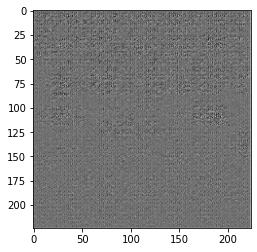

In [179]:
# On one image we check the model
output = model(batch_x[1].view(1, 3, 224, 224)).detach().numpy()
plt.imshow(output.squeeze(), cmap='gray')

### 1.4 Train the model

In [180]:
import time
start_time = time.time()

model = model.to("cuda")

# Defining the loss and optimization function
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

#Training the model
model.train()
for epoch in range(5):
    epoch_loss = cnt = 0 #initializing
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to("cuda").float()
        batch_y = batch_y.to("cuda").float()
        optimizer.zero_grad() #clearing the gradients
        outputs = model(batch_x) #passing batches of images to the models
        loss = criterion(outputs, batch_y) #deriving the loss
        loss.backward() #applying backpropogation
        optimizer.step() #gradients updates
        epoch_loss += loss.item() #summing loss and counts
        cnt += 1

    # Finding out the average losses for all batches
    epoch_loss /= cnt
    print("Training loss for epoch {} is {} ".format(epoch + 1, epoch_loss)) 


print("Training time for 5 epochs of base CNN %s seconds ---" % (time.time() - start_time))

Training loss for epoch 1 is 0.6273837426434392 
Training loss for epoch 2 is 0.5578117422435594 
Training loss for epoch 3 is 0.4909149654533552 
Training loss for epoch 4 is 0.4265980292921481 
Training loss for epoch 5 is 0.37712207436561584 
Training time for 5 epochs of base CNN 19.575265407562256 seconds ---


### 1.5 Testing the model on a single validation image

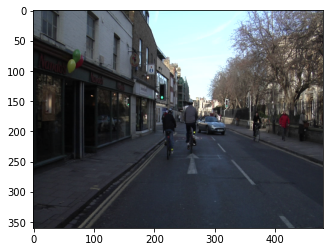

In [181]:
image = Image.open('/content/CamVid/val/0016E5_07987.png')
gt_mask = Image.open('/content/CamVid/val_labels/0016E5_07987.png')
plt.imshow(image)

In [182]:
import time
start_time = time.time()

# Mask preprocessing
gt_mask = np.array(gt_mask)
gt_mask = (gt_mask == 3)
gt_mask = Image.fromarray(gt_mask)

# Resizing
transform = Compose([Resize((224, 224)),ToTensor()])
image = transform(image)
gt_mask = transform(gt_mask)

model.eval()
output = model(image.view(1, 3, 224, 224).to("cuda")).cpu().detach().numpy()

print("Runtime for 1 image of base CNN %s seconds ---" % (time.time() - start_time))

Runtime for 1 image of base CNN 0.011220932006835938 seconds ---


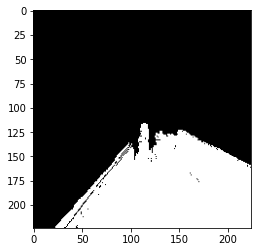

In [183]:
plt.imshow(gt_mask.squeeze(), cmap='gray') # true mask

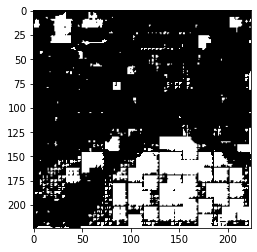

In [184]:
plt.imshow((output.squeeze() > 0.5).astype(int), cmap='gray') # predicted mask

In [185]:
mask = (output.squeeze() > 0.5).astype(int) # Converting thr predicted mask to a flattened numpy array
pred = mask.ravel().copy()

gt_mask = gt_mask.cpu().detach().numpy() # converting the ground truth mask to flattened numpy array
target = gt_mask.ravel().copy().astype(int)

pred_inds = pred == 1 # getting class indices for Lane
target_inds = target == 1

intersection = pred_inds[target_inds].sum()
union = pred_inds.sum() + target_inds.sum() - intersection

#Defining IOP Score
iou = (float(intersection) / float(max(union, 1)))
iou

0.5141338628664875

### 1.6 Mean IOU Score for validation set

In [186]:
valid_transforms = Compose([Resize((224, 224)), ToTensor()]) #preprocessing for valid dataset

valid_dataset = CamVidDataset(x_val_dir, 
    transforms=valid_transforms,training_type='valid')

# Finding out the predicted validation masks
valid_masks = []
model.eval()
with torch.no_grad():
    for valid_image in valid_dataset:
        mask = model(valid_image.unsqueeze(0).to('cuda')).cpu().detach().numpy()
        valid_masks.append(mask)
valid_masks = (np.concatenate((valid_masks), axis=0) > 0.5).astype(int)

# Finding the true validation masks

image_names = os.listdir(y_val_dir)
true_masks = []
for image_name in image_names:
  mask_path = os.path.join(y_val_dir, image_name)
  img = Image.open(mask_path)
  img = img.resize((224, 224))
  a = asarray(img)
  b = (a == 3)
  c = 1*b
  true_masks.append(c)

In [187]:
# Calculating mean IOU Score
T = []

for i in range(len(valid_dataset)):
  p = valid_masks[i].flatten()
  q = true_masks[i].flatten()
  m = tf.keras.metrics.MeanIoU(num_classes=2)
  m.update_state(p, q)
  T.append(m.result().numpy())

np.mean(T)

0.6185081

### 1.7 Mean Dice Score for validation set

In [188]:
def dice_coef(y_true, y_pred, smooth=1):
 

  intersection=(np.sum(np.array(y_pred[y_true==1])))*2
  dice = intersection / (np.sum(np.array(y_pred)) + np.sum(np.array(y_true)))
  return dice

In [189]:
T2 = []

for i in range(len(valid_dataset)):
  p2 = valid_masks[i].flatten()
  q2 = true_masks[i].flatten()
  m2 = dice_coef(p2,q2, smooth=1)
  T2.append(m2)

np.mean(T2)

0.633229649314702

# 2. DeepLabv3

DeepLab V3 is a pre-trained image segmentation model trained on the ImageNet dataset. DeepLab V3 also constitutes an encoder-decoder CNN sections with 4 improvement to the model.
1.	Depthwise Separable Convolutions: Instead of using traditional convolution layers, the  DeepLabV3 architecture splits the task into depthwise convolutions and pointwise convolutions which significantly reduces the computation time required.
2.	Spatial Pyramid Pooling: This layer removes the fixed input size constraint of the input images.
3.	Atrous Convolutions: Atrous convolutions provide a way to apply a filter over a larger area of the given image which helps in capturing the broader contextual information.

The mean IoU score obtained on the validation set was 90.89% and the mean dice score was approx 93.00%

### 2.1 Define custom dataset

In [190]:
class CamVidDataset(Dataset):
    def __init__(self, images_dir, masks_dir=None, transforms=None, training_type=None):
        #Here we get the names of all images
        self.image_names = os.listdir(images_dir)
        #Defining the training type and transforms
        self.training_type = training_type
        self.transforms = transforms

        #Defining paths of images and masks
        self.images_paths = []
        self.masks_paths = []
        for image_name in self.image_names:
            self.images_paths.append(os.path.join(images_dir, image_name))
            if self.training_type=="train" or self.training_type=="val":
                self.masks_paths.append(os.path.join(masks_dir, image_name.split('.')[0] + '.png'))
    
    def __getitem__(self, i):
        
        if self.training_type=="train" or self.training_type=="val":
            image = Image.open(self.images_paths[i])
            mask = Image.open(self.masks_paths[i])

            # preprocessing og mask
            mask = np.array(mask)
            mask = (mask == 3)
            mask = Image.fromarray(mask)

            # apply transforms
            image = self.transforms(image)
            mask = self.transforms(mask)
            return image, mask
        
        else:
            image = Image.open(self.images_paths[i])
            
            # application of transforms
            image = self.transforms(image)
            return image
        
    def __len__(self):
        return len(self.image_names)

### 2.2 Data Exploration

In [191]:
# Resizing the image >224*224 
train_transforms = Compose([Resize((224, 224)),ToTensor()])

dataset = CamVidDataset(x_train_dir, y_train_dir, transforms=train_transforms, training_type='train')
image, gt_mask = dataset[0]
image.shape, gt_mask.shape

(torch.Size([3, 224, 224]), torch.Size([1, 224, 224]))

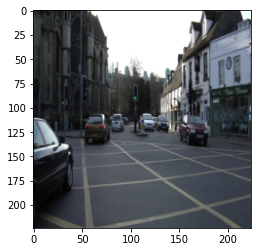

In [192]:
# Image
plt.imshow(np.transpose(image, (1, 2, 0)))

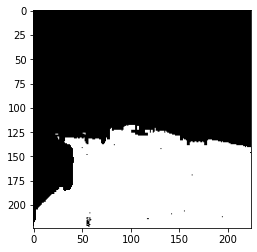

In [193]:
# Squeezed mask
plt.imshow(gt_mask.squeeze(), cmap='gray')

In [194]:
# Creating batches
train_transforms = Compose([Resize((224, 224)),ToTensor()]) #resizing
train_dataset = CamVidDataset(x_train_dir, y_train_dir, 
    transforms=train_transforms,training_type='train') #creating instanxe of custom function
train_loader = DataLoader(train_dataset, batch_size=16,
  num_workers=2) # Load dataloader

#Checking on one iteration
for batch_x, batch_y in train_loader:
    break

batch_x.shape, batch_y.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16, 1, 224, 224]))

### 2.3 Define model architecture

In [195]:
# Loading pretrained deeplab resnet model
model = deeplabv3_resnet101(pretrained=True)

for parameters in model.parameters():
    parameters.requires_grad = False

model.classifier = DeepLabHead(in_channels=2048, num_classes=1)



In [196]:
# check for one iteration of loop
for batch_x, batch_y in train_loader:
    break

# check model on one image
model.eval()
output = model(batch_x[1].view(1, 3, 224, 224))['out'].detach().numpy()

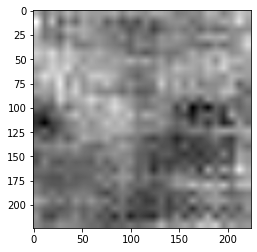

In [197]:
plt.imshow(output.squeeze(), cmap='gray') # Displaying output

### 2.4 Train the model

In [198]:
import time
start_time = time.time()

model = model.to("cuda") # sending model to GPU

# Loss and optimization function
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam([parameters for parameters in model.parameters() if parameters.requires_grad], lr=1e-3)

# Training the model
model.train()
for epoch in range(5):
    epoch_loss = cnt = 0 #initializing
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to("cuda").float()
        batch_y = batch_y.to("cuda").float()
        optimizer.zero_grad()  # clearing the gradients
        outputs = model(batch_x) # passing batches of images to model
        loss = criterion(outputs['out'], batch_y) # deriving the loss
        loss.backward() #backward pass
        optimizer.step() #gradient updates
        epoch_loss += loss.item() # sum loss and get count
        cnt += 1

    # Finding out average losses for all batches
    epoch_loss /= cnt
    print("Training loss for epoch {} is {} ".format(epoch + 1, epoch_loss))

print("--- %s seconds ---" % (time.time() - start_time))

Training loss for epoch 1 is 0.1655410317623097 
Training loss for epoch 2 is 0.08605983043494432 
Training loss for epoch 3 is 0.06928741931915283 
Training loss for epoch 4 is 0.05794289448986883 
Training loss for epoch 5 is 0.05051047630284144 
--- 69.34885716438293 seconds ---


### 2.5 Testing model on an image from validation set

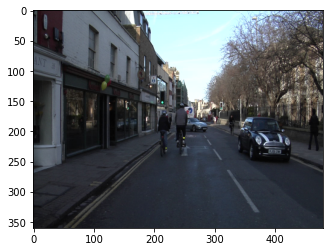

In [199]:
image = Image.open('/content/CamVid/val/0016E5_07959.png')
gt_mask = Image.open('/content/CamVid/val_labels/0016E5_07959.png')
plt.imshow(image)

In [200]:
import time
start_time = time.time()

# Mask preprocessing
gt_mask = np.array(gt_mask)
gt_mask = (gt_mask == 3)
gt_mask = Image.fromarray(gt_mask)

# Resizing
transform = Compose([Resize((224, 224)),ToTensor()])
image = transform(image)
gt_mask = transform(gt_mask)

model.eval()
output = model(image.view(1, 3, 224, 224).to("cuda"))['out'].cpu().detach().numpy()

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.08929061889648438 seconds ---


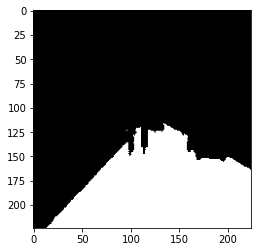

In [201]:
plt.imshow(gt_mask.squeeze(), cmap='gray') # true mask

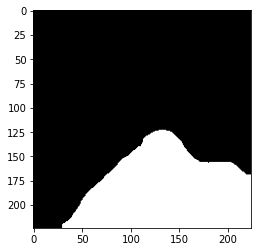

In [202]:
plt.imshow((output.squeeze() > 0.5).astype(int), cmap='gray') # predicted mask

In [203]:
mask = (output.squeeze() > 0.5).astype(int) # Converting thr predicted mask to a flattened numpy array
pred = mask.ravel().copy()

gt_mask = gt_mask.cpu().detach().numpy() # converting the ground truth mask to flattened numpy array
target = gt_mask.ravel().copy().astype(int)

pred_inds = pred == 1 # getting class indices for Lane
target_inds = target == 1

intersection = pred_inds[target_inds].sum()
union = pred_inds.sum() + target_inds.sum() - intersection

#Defining IOP Score
iou = (float(intersection) / float(max(union, 1)))
iou

0.8828904233800655

### 2.6 Mean IOU Score for validation set

In [204]:
valid_transforms = Compose([
    Resize((224, 224)), 
    ToTensor()
])

valid_dataset = CamVidDataset(
    x_val_dir, 
    transforms=valid_transforms,
    training_type='valid'
)

In [205]:
# Obtaining all predicted validation masks
valid_masks = []
model.eval()
with torch.no_grad():
    for valid_image in valid_dataset:
        mask = model(valid_image.unsqueeze(0).to('cuda'))['out'].cpu().detach().numpy()
        valid_masks.append(mask)

valid_masks = (np.concatenate((valid_masks), axis=0) > 0.5).astype(int)

In [206]:
# Obtaining true validation masks

image_names = os.listdir(y_val_dir)
true_masks = []

for image_name in image_names:
  mask_path = os.path.join(y_val_dir, image_name)
  img = Image.open(mask_path)
  img = img.resize((224, 224))
  a = asarray(img)
  b = (a == 3)
  c = 1*b
  true_masks.append(c)

In [207]:
T = []

for i in range(len(valid_dataset)):
  p = valid_masks[i].flatten()
  q = true_masks[i].flatten()
  m = tf.keras.metrics.MeanIoU(num_classes=2)
  m.update_state(p, q)
  T.append(m.result().numpy())

np.mean(T)

0.90893984

### 2.7 Mean Dice Score for validation set

In [208]:
T2 = []
for i in range(len(valid_dataset)):
  p2 = valid_masks[i].flatten()
  q2 = true_masks[i].flatten()
  m2 = dice_coef(p2,q2, smooth=1)
  T2.append(m2)
np.mean(T2)


0.9300489247915121

# 3. U-Net

DeepLab V3 is a pre-trained image segmentation model trained on the ImageNet dataset. DeepLab V3 also constitutes an encoder-decoder CNN sections along with skip connections added between the convolution and transpose convolution layers which helps in recovering fine-grained details in the decoder section.  
The base U-Net model outperformed the other 2 models that we had used, and hence we decided to improve the model further to improve its accuracy. Adding image augmentation, model checkpoint, reducing learning rate after a certain number of epochs and increasing number of epochs were the steps taken to improve the model accuracy.

The mean IoU score obtained on the validation set was 97.30% and the mean dice score was 98.04%

### 3.1 Define custom dataset

In [223]:
# custom dataset class with Data augmentation and normalization of images 

class CamVidDataset(Dataset):
    def __init__(self, images_dir, masks_dir=None, transforms=None, preprocessing=False, training_type=None):
        # Here we get names of all images
        self.image_names = os.listdir(images_dir)

        # Defining training type,transforms and preprocessing 
        self.training_type = training_type
        self.transforms = transforms
        self.preprocessing=preprocessing

        # Definining paths of images and masks
        self.images_paths = []
        self.masks_paths = []
        for image_name in self.image_names:
            self.images_paths.append(os.path.join(images_dir, image_name))
            if self.training_type=="train" or self.training_type=="val":
                self.masks_paths.append(os.path.join(masks_dir, image_name.split('.')[0] + '.png'))
    
    def __getitem__(self, i):
        
        if self.training_type=="train" or self.training_type=="val":
            image = Image.open(self.images_paths[i])
            mask = Image.open(self.masks_paths[i])

            # preprocessing of mask
            mask = np.array(mask)
            mask = (mask == 3)
            mask = Image.fromarray(mask)

            # Introducing data augmentation
            ## random horizontal flip
            if random() < 0.5:
                image, mask = F.hflip(image), F.hflip(mask)

            image = self.transforms(image)
            mask = self.transforms(mask)

            ## apply preprocessing
            if self.preprocessing:
                image = Compose([Normalize(mean=[0.485, 0.456, 0.406],        
                        std=[0.229, 0.224, 0.225])])(image)
            return image, mask
        
        else:
            image = Image.open(self.images_paths[i])
            image = self.transforms(image)

            # apply preprocessing
            if self.preprocessing:
                image = Compose([Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])])(image)  
            return image
        
    def __len__(self):
        return len(self.image_names)

In [224]:
train_transforms = Compose([Resize((224, 224)),ToTensor()]) #resizing
train_dataset = CamVidDataset(x_train_dir, y_train_dir, 
    transforms=train_transforms,training_type='train')#creating an instance of custom dataset
train_loader = DataLoader(train_dataset, batch_size=16,num_workers=2) # Load dataloader

### 3.2 Data Exploration

In [225]:
for batch_x, batch_y in train_loader:
    break
batch_x.shape, batch_y.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16, 1, 224, 224]))

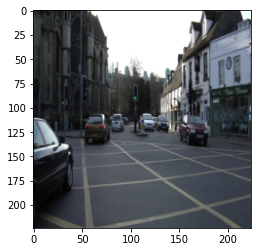

In [226]:
plt.imshow(np.transpose(batch_x[0], (1, 2, 0)))

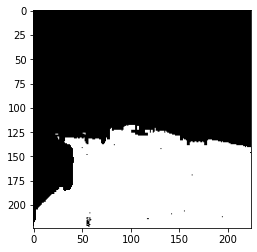

In [227]:
plt.imshow(batch_y[0].squeeze(), cmap='gray')

In [228]:

train_dataset = CamVidDataset(x_train_dir, y_train_dir, 
    transforms=train_transforms,preprocessing=True,training_type='train')# create instance of custom dataset
#Creating the dataloader
train_loader = DataLoader(train_dataset, 
    batch_size=16,num_workers=4)

### 3.3 Define model architecture

In [229]:
# Create u-net with a pretrained encoder
model = smp.Unet(encoder_name='resnet18', encoder_weights='imagenet', classes=1, activation='sigmoid')
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [230]:
for batch_x, batch_y in train_loader:
    break
# Running model for one image
model.eval()
output = model(batch_x[1].view(1, 3, 224, 224)).detach().numpy()

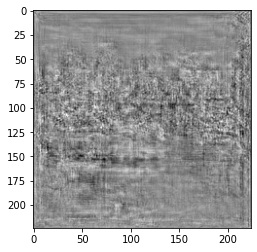

In [231]:
# print output
plt.imshow(output.squeeze(), cmap='gray')

### 3.4 Train the model

In [232]:
import time
start_time = time.time()

criterion = smp.utils.losses.BCELoss() # Loss function
optimizer = torch.optim.Adam([parameters for parameters in model.parameters() if parameters.requires_grad], lr=1e-3) #Optimizer
metrics = [smp.utils.metrics.IoU(threshold=0.5)] #Evaluation metric

train_epoch = smp.utils.train.TrainEpoch(
    model, loss=criterion, metrics=metrics, optimizer=optimizer,device='cuda',verbose=True,)

# Saving best model and Decrease in LR after 10th epoch added for U-Net model
max_score = 0

for i in range(0, 20):
    print('\nEpoch: {}'.format(i + 1))
    train_logs = train_epoch.run(train_loader)
    if max_score < train_logs['iou_score']:
        max_score = train_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
    # decreasing learning rate after 10th epoch
    if i+1 == 10:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease learning rate to 1e-5')

print("--- %s seconds ---" % (time.time() - start_time))


Epoch: 1
train: 100%|██████████| 23/23 [00:04<00:00,  4.69it/s, bce_loss - 0.2585, iou_score - 0.8061]
Model saved!

Epoch: 2
train: 100%|██████████| 23/23 [00:04<00:00,  4.77it/s, bce_loss - 0.08693, iou_score - 0.9251]
Model saved!

Epoch: 3
train: 100%|██████████| 23/23 [00:04<00:00,  4.82it/s, bce_loss - 0.06016, iou_score - 0.9419]
Model saved!

Epoch: 4
train: 100%|██████████| 23/23 [00:04<00:00,  4.90it/s, bce_loss - 0.04816, iou_score - 0.9505]
Model saved!

Epoch: 5
train: 100%|██████████| 23/23 [00:06<00:00,  3.52it/s, bce_loss - 0.04053, iou_score - 0.9566]
Model saved!

Epoch: 6
train: 100%|██████████| 23/23 [00:04<00:00,  4.83it/s, bce_loss - 0.03627, iou_score - 0.9606]
Model saved!

Epoch: 7
train: 100%|██████████| 23/23 [00:04<00:00,  4.80it/s, bce_loss - 0.0331, iou_score - 0.9629]
Model saved!

Epoch: 8
train: 100%|██████████| 23/23 [00:04<00:00,  4.91it/s, bce_loss - 0.03084, iou_score - 0.9657]
Model saved!

Epoch: 9
train: 100%|██████████| 23/23 [00:04<00:00,  4.8

In [233]:
# Loading the best saved point
model = torch.load('./best_model.pth')

### 3.5 Testing the model on a single validation image

In [234]:
image = Image.open('/content/CamVid/val/0016E5_07987.png')
gt_mask = Image.open('/content/CamVid/val_labels/0016E5_07987.png')

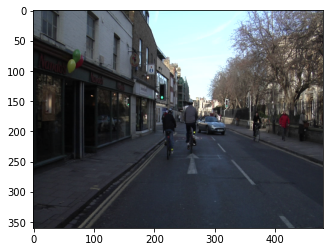

In [235]:
plt.imshow(image)

In [236]:
import time
start_time = time.time()

# preprocessing of mask
gt_mask = np.array(gt_mask)
gt_mask = (gt_mask == 3)
gt_mask = Image.fromarray(gt_mask)

# Preprocess
transform = Compose([Resize((224, 224)),ToTensor()]) #Resizing
image = transform(image)
image = Compose([Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])])(image)
gt_mask = transform(gt_mask)

model.eval()
output = model(image.view(1, 3, 224, 224).to("cuda")).cpu().detach().numpy()

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.02144002914428711 seconds ---


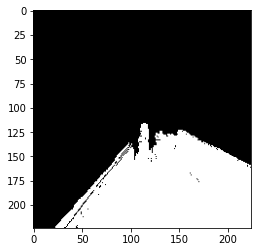

In [237]:
# Actual mask
plt.imshow(gt_mask.squeeze(), cmap='gray')

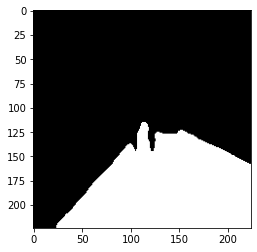

In [238]:
# predicted mask
plt.imshow((output.squeeze() > 0.5).astype(int), cmap='gray')

In [239]:
mask = (output.squeeze() > 0.5).astype(int) # Converting thr predicted mask to a flattened numpy array
pred = mask.ravel().copy()

gt_mask = gt_mask.cpu().detach().numpy() # converting the ground truth mask to flattened numpy array
target = gt_mask.ravel().copy().astype(int)

pred_inds = pred == 1 # getting class indices for Lane
target_inds = target == 1

intersection = pred_inds[target_inds].sum()
union = pred_inds.sum() + target_inds.sum() - intersection

#Defining IOP Score
iou = (float(intersection) / float(max(union, 1)))
iou

0.9683032939714108

### 3.6 Mean IOU Score for validation set

In [240]:
valid_transforms = Compose([
    Resize((224, 224)), 
    ToTensor()
])

valid_dataset = CamVidDataset(
    x_val_dir, 
    transforms=valid_transforms,
    preprocessing=True,
    training_type='valid'
)

In [241]:
# Obtaining all predicted validation masks
valid_masks = []
model.eval()
with torch.no_grad():
    for valid_image in valid_dataset:
        mask = model(valid_image.unsqueeze(0).to('cuda')).cpu().detach().numpy()
        valid_masks.append(mask)

valid_masks = (np.concatenate((valid_masks), axis=0) > 0.5).astype(int)

In [242]:
# Obtaining true validation masks

transform = Compose([Resize((224, 224)),ToTensor()])

image_names = os.listdir(y_val_dir)
true_masks = []

for image_name in image_names:
  mask_path = os.path.join(y_val_dir, image_name)
  img = Image.open(mask_path)
  gt_mask = np.array(img)
  gt_mask = (gt_mask == 3)
  gt_mask = Image.fromarray(gt_mask)
  gt_mask = transform(gt_mask)
  true_masks.append(gt_mask)

In [243]:
T = []

for i in range(len(valid_dataset)):
  p = valid_masks[i].flatten()
  q = true_masks[i].flatten()
  m = tf.keras.metrics.MeanIoU(num_classes=2)
  m.update_state(p, q)
  T.append(m.result().numpy())

np.mean(T)

0.9730491

### 3.7 Mean Dice Score for validation set

In [244]:
T2 = []

for i in range(len(valid_dataset)):
  p2 = valid_masks[i].flatten()
  q2 = true_masks[i].flatten()
  m2 = dice_coef(p2,q2, smooth=1)
  T2.append(m2)

np.mean(T2)


0.9805022089491795

# 4. Inference on test dataset (applying Model 3 - UNet)

### 4.1 Obtaining prediction masks for test set

In [245]:
test_transforms = Compose([Resize((224, 224)), ToTensor()]) #resize

test_dataset = CamVidDataset(x_test_dir, transforms=test_transforms,preprocessing=True,training_type='test')

In [246]:
# running the model for all images in test dataset
test_masks = []
model.eval()
with torch.no_grad():
    for test_image in test_dataset:
        mask = model(test_image.unsqueeze(0).to('cuda')).cpu().detach().numpy()
        test_masks.append(mask)

test_masks = (np.concatenate((test_masks), axis=0) > 0.5).astype(int)

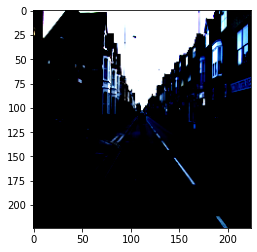

In [247]:
# display image(original)
test_image = test_dataset[100]
plt.imshow(np.transpose(test_image, (1, 2, 0)))

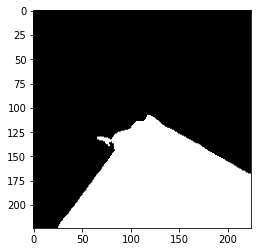

In [248]:
# display prediction
plt.imshow((test_masks[100]).squeeze(), cmap='gray')

### 4.2 True mask for test set

In [249]:
# Obtaining true validation masks

transform = Compose([Resize((224, 224)),ToTensor()]) #resizw
image_names = os.listdir(y_test_dir)
true_masks = []

for image_name in image_names:
  mask_path = os.path.join(y_test_dir, image_name)
  img = Image.open(mask_path)
  gt_mask = np.array(img)
  gt_mask = (gt_mask == 3)
  gt_mask = Image.fromarray(gt_mask)
  gt_mask = transform(gt_mask)
  true_masks.append(gt_mask)

### 4.3 Mean IOU score for test set

In [250]:
T = []

for i in range(len(test_dataset)):
  p = test_masks[i].flatten()
  q = true_masks[i].flatten()
  m = tf.keras.metrics.MeanIoU(num_classes=2)
  m.update_state(p, q)
  T.append(m.result().numpy())

np.mean(T)

0.91890377

### 4.4 Mean Dice score for test set

In [252]:
T2 = []

for i in range(len(test_dataset)):
  p2 = test_masks[i].flatten()
  q2 = true_masks[i].flatten()
  m2 = dice_coef(p2,q2, smooth=1)
  T2.append(m2)

np.mean(T2)

0.9351180475652184

# CONCLUSION

### U-Net model seems to outperform other models in terms of accuracy providing an IoU of 91.89% and Dice score of 93.51% on unseen test set. Along with providing a better accuracy, U-Net also evaluates images 4 times faster than the DeepLab model.

### However, the model does seem to overfit a bit, and adding regularization to the model might help with performance over test set.